In [1]:
import numpy as np
import matplotlib.pyplot as plt

from blackscholes import EuropeanOptionPricer

# Part I: Delta: Closed Form Method vs Monte Carlo Method

### Calculate Delta with Closed Form Formula

In [2]:
# define parameters
# example AAPL @ 3 May 5:06pm HKT
S_params = {
    'S': 131.46, # yahoo finance
    'sigma': 0.1879, # alpha query - Historical Volatility (0.1879)
    'r': 0.0025, # Fed rate 
    'T': 5/252, # yahoo finance
    'K': 120 # yahoo finance
}

V_mkt = 11.29 # last call price from yahoo finance
h = 1 # self-calculated

In [3]:
eop = EuropeanOptionPricer(**S_params)
V = eop.get_call_premium()
print('Call value(S):',V)

Call value(S): 11.466190970008569


$$\frac{\partial V(S)}{\partial S} \approx \frac{V(S+h)-V(S)}{h}$$ 

In [4]:
Sh_params = S_params
Sh_params['S'] += h

In [5]:
eop = EuropeanOptionPricer(**Sh_params)
Vh = eop.get_call_premium()
print('Call value(S+h):',V)

Call value(S+h): 11.466190970008569


In [6]:
delta1 = (Vh - V)/h
print('Delta is', delta1)

Delta is 0.9998361981468094


### What if h is smaller

In [7]:
# now if h is small~~
h = 0.00001 # self-calculated

In [8]:
eop = EuropeanOptionPricer(**S_params)
V = eop.get_call_premium()
print('Call value(S):',V)

Call value(S): 12.466027168155378


$$\frac{\partial V(S)}{\partial S} \approx \frac{V(S+h)-V(S)}{h}$$ 

In [9]:
Sh_params = S_params
Sh_params['S'] += h

In [10]:
eop = EuropeanOptionPricer(**Sh_params)
Vh = eop.get_call_premium()
print('Call value(S+h):',V)

Call value(S+h): 12.466027168155378


In [11]:
delta3 = (Vh - V)/h
print('Delta is', delta3)

Delta is 0.9999107263070072


### Calculate Delta with Monte Carlo
Require special dependency for Quasi number generator

In [12]:
from montecarlo import MonteCarloSimulator

In [13]:
# define parameters
# example AAPL @ 3 May 5:06pm HKT

K = 65
h = 1

S_params = {
    'S': 131.46, # yahoo finance
    'sigma': 0.3, # alpha query - Historical Volatility (0.1879)
    'r': 0.0025, # Fed rate 
    'T': 5/252, # yahoo finance
    'n': 50,
    'm': 1e4
}

$$\Delta \approx e^{-rT} \frac{\mathbb{E}(Y(S+h) - \mathbb{E}(Y(S))}{h}$$ 

In [14]:
msc = MonteCarloSimulator(**S_params)
S_paths = msc.run_simulation(rand_type='quasi')
STs = S_paths[:,-1]
STs[(STs-K)<0] = 0
expected_call = STs.mean()

In [15]:
# delta params
Sh_params = S_params
Sh_params['S'] += h
msc = MonteCarloSimulator(**Sh_params)
S_paths = msc.run_simulation(rand_type='quasi')
STs = S_paths[:,-1]
STs[(STs-K)<0] = 0
expected_call_h = STs.mean()

In [16]:
delta2 = np.exp(-S_params['r']*S_params['T']) * (expected_call_h - expected_call)/h 
print('Delta is', delta2)

Delta is 0.9997514568703255


### Conclusion

In [17]:
diff = delta2/delta1-1
print('% difference between the two is {:.2f}%'.format(diff*100))

% difference between the two is -0.01%


# Part II: Exploring Delta Hedging

## Stop Loss Hedging

Essentially:
1. Own stock when in-the-money
2. Do not own stock when out-of-the-money

In [18]:
Szero = 49
sigma = 0.30
r = 0.04
mu = 0.13
T = 0.25
K = 50
Dt = 1e-2
N = int(T/Dt)
t = np.arange(0,T,Dt)
M = 1000

In [19]:
asset = np.zeros(N) # No. of shares
cash = np.zeros(N) # Cash/Zero-coupon Bond
portfolio = np.zeros(N) # Value of Asset + Cash

S = np.zeros(N) # Stock price path
V = np.zeros(N) # Option price path

In [20]:
stopLossHedging = np.zeros(M)
options = np.zeros(M)

In [21]:
# set up values at t=0
eop = EuropeanOptionPricer(S=Szero, K=K, r=r, sigma=sigma, T=T-t[0])
C = eop.get_call_premium()

# check whether C is approx 2.7, same as value provided in lecture 8
np.testing.assert_approx_equal(C,2.7,5)

S[0] = Szero
if S[0] >= K:
    # buy stock if S > K
    asset[0] = 1
else:
    # sell stock if K > S
    asset[0] = 0
cash[1] = C - asset[0] * S[0]
portfolio[0] = C

In [22]:
# for each simulation path
for j in range(M):
    # for each time period
    for i in range(1, N):
        # get next stock price
        S[i] = S[i-1]*np.exp((mu-0.5*sigma**2)*Dt + sigma*np.sqrt(Dt)*np.random.standard_normal())
        eop = EuropeanOptionPricer(S=S[i], K=K, r=r, sigma=sigma, T=T-t[i])
        # get call option price
        V[i] = eop.get_call_premium()
        # stop loss hedging
        portfolio[i] = asset[i-1]*S[i] + cash[i-1]*(1+r*Dt)
        if S[i] >= K:
            asset[i] = 1
        else:
            asset[i] = 0
        cash[i] = portfolio[i] - asset[i]*S[i]
    options[j] = V[-1]
    stopLossHedging[j] = portfolio[-1]

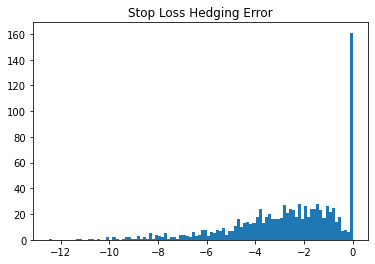

mean_error: -2.6940258613109744
std_dev: 2.2818286662654925
max_error: -0.4121971950454819
min_error: -4.975854527576467


In [23]:
stopLossError = stopLossHedging - options
meanStopLossError = stopLossError.mean()
stdStopLossError = stopLossError.std()

plt.hist(stopLossError, 100)
plt.title('Stop Loss Hedging Error')
plt.show()

print('mean_error:',meanStopLossError)
print('std_dev:', stdStopLossError)
print('max_error:', meanStopLossError+stdStopLossError)
print('min_error:', meanStopLossError-stdStopLossError)

## Delta Hedging

In [24]:
def get_C_and_Cdelta(S, K, r, sigma, T, h):
    eop = EuropeanOptionPricer(S=S, K=K, r=r, sigma=sigma, T=T)
    C = eop.get_call_premium()
    eop = EuropeanOptionPricer(S=S+h, K=K, r=r, sigma=sigma, T=T)
    Ch = eop.get_call_premium()
    Cdelta = (C - Ch) / h
    return C, Cdelta

In [25]:
# setup placeholders for 
deltaHedging = np.zeros(M)
options = np.zeros(M)

asset = np.zeros(N) # No. of shares
cash = np.zeros(N) # Cash/Zero-coupon Bond
portfolio = np.zeros(N) # Value of Asset + Cash

S = np.zeros(N) # Stock price path
V = np.zeros(N) # Option price path

C, Cdelta = get_C_and_Cdelta(S=Szero, K=K, r=r, sigma=sigma, T=T-t[0], h=1)
print(C, Cdelta)

V[0] = C
S[0] = Szero

asset[0] = Cdelta
cash[0] = C - asset[0] * S[0]
portfolio[0] = C

2.700049921567583 -0.5296916672603125


In [26]:
# for each simulation path
for j in range(M):
    # for each time period
    for i in range(1, N):
        # get next stock price
        S[i] = S[i-1]*np.exp((mu-0.5*sigma**2)*Dt + sigma*np.sqrt(Dt)*np.random.standard_normal())
        portfolio[i] = asset[i-1]*S[i] + cash[i-1]*(1+r*Dt)
        C, Cdelta = get_C_and_Cdelta(S=S[i], K=K, r=r, sigma=sigma, T=T-t[i], h=1)
        asset[i] = Cdelta
        cash[i] = portfolio[i] - asset[i]*S[i]
        V[i] = C
    options[j] = V[-1]
    deltaHedging[j] = portfolio[-1]

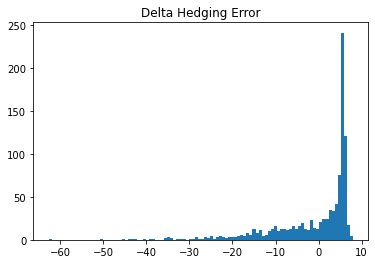

mean_error: -0.9663755063142382
std_dev: 9.6596422782014
max_error: 8.693266771887162
min_error: -10.626017784515637


In [27]:
deltaError = deltaHedging - options
meanDeltaError = deltaError.mean()
stdDeltaError = deltaError.std()

plt.hist(deltaError, 100)
plt.title('Delta Hedging Error')
plt.show()

print('mean_error:',meanDeltaError)
print('std_dev:', stdDeltaError)
print('max_error:', meanDeltaError+stdDeltaError)
print('min_error:', meanDeltaError-stdDeltaError)

### Comparison

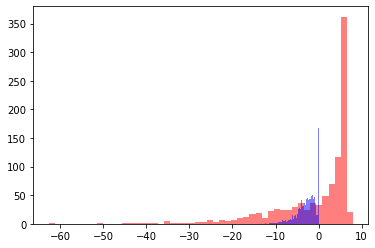

In [28]:
plt.hist(deltaError, 50, color='r', alpha=0.5)
plt.hist(stopLossError, 50, color='b', alpha=0.5)
plt.show() # quite a rubbish comparison but it shows something...